In [1]:
import numpy as np

import nengo
from nengo.params import Default
from nengo.dists import Uniform
from nengo.solvers import LstsqL2, NoSolver
from nengo.neurons import Direct

from nengolib import Lowpass, DoubleExp
from nengolib.signal import s, z, nrmse, LinearSystem
from nengolib.synapses import ss2sim

from train import dh_hyperopt, dh_lstsq, gbopt, d_lstsq
from neuron_models import AdaptiveLIFT, WilsonEuler, DurstewitzNeuron, reset_neuron

import neuron

import warnings

import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
sns.set(context='poster', style='white')

	1 


/home/pduggins/.local/share/virtualenvs/detailed_neurons-h7DZlJyC/lib/python3.7/site-packages/nengo/builder/builder.py:234: UserWarning: Type '<class 'nengo.connection.Connection'>' already has a builder. Overwriting.
  % nengo_class)


In [2]:
def go(n_neurons=3000, t_train=30, t_test=30, t_supv=1, n_trains=5, n_tests=5, 
       max_rates=Uniform(20, 40), intercepts=Uniform(-1, 1), radius=40, sigma=10, beta=8.0/3, rho=28,
       freq=1, seed=0, dt=0.001, h_tar=Lowpass(0.1), reg=1e-1, gbd=dict(), gb_iter=0, h_iter=10, order=2):

    h_tar.tau = 0.1
    h_lif, h_alif, h_wilson, h_durstewitz = h_tar, h_tar, h_tar, h_tar
    d_lif, d_alif, d_wilson, d_durstewitz = np.zeros((n_neurons, 3)), np.zeros((n_neurons, 3)), np.zeros((n_neurons, 3)), np.zeros((n_neurons, 3))
    
    solver_nef = LstsqL2(reg=reg)
    solver_lif = NoSolver(d_lif)
    solver_alif = NoSolver(d_alif)
    solver_wilson = NoSolver(d_wilson)
    solver_durstewitz = NoSolver(d_durstewitz)

    def feedback(x):
        dx = sigma * (x[1] - x[0])
        dy = x[0] * (rho - x[2]) - x[1]
        dz = x[0] * x[1] - beta *x[2]
        return [dx, dy, dz]
    
    '''Decoders from supv to ens and gain/bias optimization for bioneurons'''
    with nengo.Network(seed=0) as model:
        supv = nengo.Ensemble(n_neurons, 3, neuron_type=nengo.SpikingRectifiedLinear(), max_rates=max_rates, intercepts=intercepts, radius=radius, seed=0)
        durstewitz = nengo.Ensemble(n_neurons, 3, max_rates=max_rates, intercepts=intercepts, neuron_type=DurstewitzNeuron(), seed=0, radius=radius, label='durstewitz')
        ff = nengo.Connection(supv, durstewitz, synapse=h_tar, seed=0, label='ff')
    if gb_iter:
        gbd = gbopt([ff], gb_iter=gb_iter, pt=False)
    with nengo.Simulator(model, dt=dt, seed=0) as sim:
        neuron.h.init()
        d_supv = sim.data[ff].weights.T
        reset_neuron(sim)

    A_lif = np.zeros((n_trains, int(t_train/dt), n_neurons))
    A_alif = np.zeros((n_trains, int(t_train/dt), n_neurons))
    A_wilson = np.zeros((n_trains, int(t_train/dt), n_neurons))
    A_durstewitz = np.zeros((n_trains, int(t_train/dt), n_neurons))
    targets = np.zeros((n_trains, int(t_train/dt), 3))

    '''Network definition'''
    for n in range(n_trains):
        print('supervision %s'%n)
        rng = np.random.RandomState(seed=n)
#         initial_conditions = np.array([rng.uniform(-15, 15), rng.uniform(-20, 20), rng.uniform(10, 35)])
        initial_conditions = np.array([rng.uniform(-radius, radius), rng.uniform(-radius, radius), rng.uniform(-radius, radius)])
        with nengo.Network(seed=0) as model:
            # Ensembles
            u = nengo.Node(lambda t: initial_conditions*(t<=dt))
            tar = nengo.Ensemble(1, 3, neuron_type=Direct())
            supv = nengo.Ensemble(n_neurons, 3, neuron_type=nengo.SpikingRectifiedLinear(), max_rates=max_rates, intercepts=intercepts, radius=radius, seed=0)
            lif = nengo.Ensemble(n_neurons, 3, max_rates=max_rates, intercepts=intercepts, neuron_type=nengo.LIF(), seed=0, radius=radius, label='lif')
            alif = nengo.Ensemble(n_neurons, 3, max_rates=max_rates, intercepts=intercepts, neuron_type=AdaptiveLIFT(tau_adapt=0.1, inc_adapt=0.1), seed=0, radius=radius, label='alif')
            wilson = nengo.Ensemble(n_neurons, 3, max_rates=max_rates, intercepts=intercepts, neuron_type=WilsonEuler(), seed=0, radius=radius, label='wilson')
#             durstewitz = nengo.Ensemble(n_neurons, 3, max_rates=max_rates, intercepts=intercepts, neuron_type=DurstewitzNeuron(), seed=0, radius=radius, label='durstewitz')
            # Connections
            nengo.Connection(u, tar, synapse=None)
            nengo.Connection(tar, tar, function=feedback, synapse=~s)
            nengo.Connection(tar, supv, synapse=None)
            ff_lif = nengo.Connection(supv, lif, synapse=h_tar, solver=NoSolver(d_supv), label='ff_lif', seed=0)
            ff_alif = nengo.Connection(supv, alif, synapse=h_tar, solver=NoSolver(d_supv), label='ff_alif', seed=0)
            ff_wilson = nengo.Connection(supv, wilson, synapse=h_tar, solver=NoSolver(d_supv), label='ff_wilson', seed=0)
#             ff_durstewitz = nengo.Connection(supv, durstewitz, synapse=h_tar, solver=NoSolver(d_supv), label='ff_lif', seed=0)
            fb_lif = nengo.Connection(lif, lif, synapse=h_lif, solver=NoSolver(d_lif), label='fb_lif', seed=0)
            fb_alif = nengo.Connection(alif, alif, synapse=h_alif, solver=NoSolver(d_alif), label='fb_alif', seed=0)
            fb_wilson = nengo.Connection(wilson, wilson, synapse=h_wilson, solver=NoSolver(d_wilson), label='fb_wilson', seed=0)
#             fb_durstewitz = nengo.Connection(durstewitz, durstewitz, synapse=h_durstewitz, solver=NoSolver(d_durstewitz), label='fb_durstewitz', seed=0)
            # probes
            p_u = nengo.Probe(u, synapse=None)
            p_tar = nengo.Probe(tar, synapse=None)
    #         p_nef = nengo.Probe(nef, synapse=h_tar)
            p_lif = nengo.Probe(lif.neurons, synapse=None)
            p_alif = nengo.Probe(alif.neurons, synapse=None)
            p_wilson = nengo.Probe(wilson.neurons, synapse=None)
#             p_durstewitz = nengo.Probe(durstewitz.neurons, synapse=None)
#         if any(gbd):
#             with warnings.catch_warnings():
#                 warnings.simplefilter("ignore")
#                 ff_durstewitz.gain = gbd['ff']['gain']
#                 ff_durstewitz.bias = gbd['ff']['bias']
#                 fb_durstewitz.gain = gbd['ff']['gain']
#                 fb_durstewitz.bias = gbd['ff']['bias']
        with nengo.Simulator(model, seed=0, dt=dt) as sim:
#             neuron.h.init()
            sim.run(t_supv)
            sim.run(t_train)
#             reset_neuron(sim)
        A_lif[n] = sim.data[p_lif][int(t_supv/dt):]
        A_alif[n] = sim.data[p_alif][int(t_supv/dt):]
        A_wilson[n] = sim.data[p_wilson][int(t_supv/dt):]
#         A_durstewitz[n] = sim.data[p_durtewitz]
        targets[n] = h_tar.filt(sim.data[p_tar][int(t_supv/dt):], dt=dt)

    '''Optimize d and h'''
    A_lif = A_lif.reshape((n_trains*int(t_train/dt), n_neurons))
    A_alif = A_alif.reshape((n_trains*int(t_train/dt), n_neurons))
    A_wilson = A_wilson.reshape((n_trains*int(t_train/dt), n_neurons))
#     A_durstewitz = A_durstewitz.reshape((n_trains*int(t_train/dt), n_neurons))
    targets = targets.reshape((n_trains*int(t_train/dt), 3))
    d_lif, h_lif= dh_hyperopt(targets, A_lif, order=order, h_iter=h_iter, dt=dt, tau_mins=[0.1, 0.01], tau_maxs=[0.2, 0.05], name='lorenz_lif')
    d_alif, h_alif = dh_hyperopt(targets, A_alif, order=order, h_iter=h_iter, dt=dt, tau_mins=[0.1, 0.01], tau_maxs=[0.2, 0.05], name='lorenz_alif')
    d_wilson, h_wilson = dh_hyperopt(targets, A_wilson, order=order, h_iter=h_iter, dt=dt, tau_mins=[0.1, 0.01], tau_maxs=[0.2, 0.05], name='lorenz_wilson')
#     d_durstewitz, h_durstewitz = dh_hyperopt(targets, A_durstewitz, order=order, h_iter=h_iter, dt=dt, tau_mins=[0.1, 0.01], tau_maxs=[0.2, 0.05], name='lorenz_durstewitz')
    times = np.arange(0, 1, 0.0001)
    fig, ax = plt.subplots(figsize=((12, 8)))
    ax.plot(times, h_tar.impulse(len(times), dt=0.0001), label="h_tar")
    ax.plot(times, h_lif.impulse(len(times), dt=0.0001), label="h_lif")
    ax.plot(times, h_alif.impulse(len(times), dt=0.0001), label="h_alif")
    ax.plot(times, h_wilson.impulse(len(times), dt=0.0001), label="h_wilson")
#     ax.plot(times, h_durstewitz.impulse(len(times), dt=0.0001), label="h_durstewitz")
    ax.set(xlabel='time (seconds)', ylabel='impulse response', ylim=((0, 10)))
    ax.legend(loc='upper right')
    plt.tight_layout()
    plt.show()
    
    fig = plt.figure(figsize=(12, 8))    
    ax_lif = fig.add_subplot(221, projection='3d')
    ax_alif = fig.add_subplot(222, projection='3d')
    ax_wilson = fig.add_subplot(223, projection='3d')
    ax_tar = fig.add_subplot(224, projection='3d')
    ax_lif.set(title="LIF")  # xlabel='$x$', ylabel="$y$", zlabel='$z$', 
    ax_alif.set(title="ALIF")  # xlabel='$x$', ylabel="$y$", zlabel='$z$', 
    ax_wilson.set(title="Wilson")  # xlabel='$x$', ylabel="$y$", zlabel='$z$', 
    ax_tar.set(title="Target")  # xlabel='$x$', ylabel="$y$", zlabel='$z$', 
    a_lif = h_lif.filt(sim.data[p_lif], dt=dt)
    a_alif = h_alif.filt(sim.data[p_alif], dt=dt)
    a_wilson = h_wilson.filt(sim.data[p_wilson], dt=dt)
    tar = h_tar.filt(sim.data[p_tar], dt=dt)
    times = sim.trange()
    xhat_lif = np.dot(a_lif, d_lif)
    xhat_alif = np.dot(a_alif, d_alif)
    xhat_wilson = np.dot(a_wilson, d_wilson)
    ax_lif.plot(*xhat_lif[int(t_supv/dt):].T)
    ax_alif.plot(*xhat_alif[int(t_supv/dt):].T)
    ax_wilson.plot(*xhat_wilson[int(t_supv/dt):].T)
    ax_tar.plot(*tar[int(t_supv/dt):].T)
    plt.show()
    
            
    '''Run test trials with recurrence and no supervision.
    Each test trial starts with unique initial conditions'''
    fig = plt.figure(figsize=(12, 8))    
    ax_lif = fig.add_subplot(221, projection='3d')
    ax_alif = fig.add_subplot(222, projection='3d')
    ax_wilson = fig.add_subplot(223, projection='3d')
    ax_tar = fig.add_subplot(224, projection='3d')
    ax_lif.set(title="LIF")  # xlabel='$x$', ylabel="$y$", zlabel='$z$', 
    ax_alif.set(title="ALIF")  # xlabel='$x$', ylabel="$y$", zlabel='$z$', 
    ax_wilson.set(title="Wilson")  # xlabel='$x$', ylabel="$y$", zlabel='$z$', 
    ax_tar.set(title="Target")  # xlabel='$x$', ylabel="$y$", zlabel='$z$', 
#     ax_durstewitz = fig.add_subplot(111, projection='3d')
#     ax_durstewitz.set(xlabel='$x$', ylabel="$y$", zlabel='$z$', title="Durstewitz")
    for n in range(n_tests):
        print('trial %s'%n)
        rng = np.random.RandomState(seed=n)
#         initial_conditions = np.array([rng.uniform(-15, 15), rng.uniform(-20, 20), rng.uniform(10, 35)])
        initial_conditions = np.array([rng.uniform(-radius, radius), rng.uniform(-radius, radius), rng.uniform(-radius, radius)])
        with nengo.Network(seed=0) as model:
            # Ensembles
            u = nengo.Node(lambda t: initial_conditions*(t<=dt))
            tar = nengo.Ensemble(1, 3, neuron_type=Direct())
            supv = nengo.Ensemble(n_neurons, 3, neuron_type=nengo.SpikingRectifiedLinear(), max_rates=max_rates, intercepts=intercepts, radius=radius, seed=0)
            lif = nengo.Ensemble(n_neurons, 3, max_rates=max_rates, intercepts=intercepts, neuron_type=nengo.LIF(), seed=0, radius=radius, label='lif')
            alif = nengo.Ensemble(n_neurons, 3, max_rates=max_rates, intercepts=intercepts, neuron_type=AdaptiveLIFT(tau_adapt=0.1, inc_adapt=0.1), seed=0, radius=radius, label='alif')
            wilson = nengo.Ensemble(n_neurons, 3, max_rates=max_rates, intercepts=intercepts, neuron_type=WilsonEuler(), seed=0, radius=radius, label='wilson')
#             durstewitz = nengo.Ensemble(n_neurons, 3, max_rates=max_rates, intercepts=intercepts, neuron_type=DurstewitzNeuron(), seed=0, radius=radius, label='durstewitz')
            # Connections
            nengo.Connection(u, tar, synapse=None)
            nengo.Connection(tar, tar, function=feedback, synapse=~s)
            nengo.Connection(tar, supv, synapse=None)
            ff_lif = nengo.Connection(supv, lif, synapse=h_tar, solver=NoSolver(d_supv), label='ff_lif', seed=0)
            ff_alif = nengo.Connection(supv, alif, synapse=h_tar, solver=NoSolver(d_supv), label='ff_alif', seed=0)
            ff_wilson = nengo.Connection(supv, wilson, synapse=h_tar, solver=NoSolver(d_supv), label='ff_wilson', seed=0)
#             ff_durstewitz = nengo.Connection(supv, durstewitz, synapse=h_tar, solver=NoSolver(d_supv), label='ff_lif', seed=0)
            fb_lif = nengo.Connection(lif, lif, synapse=h_lif, solver=NoSolver(d_lif), label='fb_lif', seed=0)
            fb_alif = nengo.Connection(alif, alif, synapse=h_alif, solver=NoSolver(d_alif), label='fb_alif', seed=0)
            fb_wilson = nengo.Connection(wilson, wilson, synapse=h_wilson, solver=NoSolver(d_wilson), label='fb_wilson', seed=0)
#             fb_durstewitz = nengo.Connection(durstewitz, durstewitz, synapse=h_durstewitz, solver=NoSolver(d_durstewitz), label='fb_durstewitz', seed=0)
            # probes
            p_u = nengo.Probe(u, synapse=None)
            p_tar = nengo.Probe(tar, synapse=None)
    #         p_nef = nengo.Probe(nef, synapse=h_tar)
            p_lif = nengo.Probe(lif.neurons, synapse=None)
            p_alif = nengo.Probe(alif.neurons, synapse=None)
            p_wilson = nengo.Probe(wilson.neurons, synapse=None)
#             p_durstewitz = nengo.Probe(durstewitz.neurons, synapse=None)
#         if any(gbd):
#             with warnings.catch_warnings():
#                 warnings.simplefilter("ignore")
#                 ff_durstewitz.gain = gbd['ff']['gain']
#                 ff_durstewitz.bias = gbd['ff']['bias']
#                 fb_durstewitz.gain = gbd['ff']['gain']
#                 fb_durstewitz.bias = gbd['ff']['bias']
        with nengo.Simulator(model, seed=0, dt=dt) as sim:
    #         neuron.h.init()
            '''Add supervision and remove recurrence'''
    #         for conn in model.connections:
    #             if conn == ff_durstewitz:
    #                 op = conn.transmitspike
    #                 for pre in range(op.synapses.shape[0]):
    #                     for post in range(op.synapses.shape[1]):
    #                         for compt in range(len(op.synapses[pre, post])):
    #                             op.netcons[pre, post][compt].weight[0] = np.abs(op.weights[pre, post])
    #             if conn == fb_durstewitz:
    #                 op = conn.transmitspike
    #                 for pre in range(op.synapses.shape[0]):
    #                     for post in range(op.synapses.shape[1]):
    #                         for compt in range(len(op.synapses[pre, post])):
    #                             op.netcons[pre, post][compt].weight[0] = 0
            sim.signals[sim.model.sig[ff_lif]['weights']][:] = d_supv.T
            sim.signals[sim.model.sig[ff_alif]['weights']][:] = d_supv.T
            sim.signals[sim.model.sig[ff_wilson]['weights']][:] = d_supv.T
            sim.signals[sim.model.sig[fb_lif]['weights']][:] = 0
            sim.signals[sim.model.sig[fb_alif]['weights']][:] = 0
            sim.signals[sim.model.sig[fb_wilson]['weights']][:] = 0
            sim.run(t_supv)
            '''Remove supervision and add recurrence'''
    #         for conn in model.connections:
    #             if conn == ff_durstewitz:
    #                 op = conn.transmitspike
    #                 for pre in range(op.synapses.shape[0]):
    #                     for post in range(op.synapses.shape[1]):
    #                         for compt in range(len(op.synapses[pre, post])):
    #                             op.netcons[pre, post][compt].weight[0] = 0
    #             if conn == fb_durstewitz:
    #                 op = conn.transmitspike
    #                 for pre in range(op.synapses.shape[0]):
    #                     for post in range(op.synapses.shape[1]):
    #                         for compt in range(len(op.synapses[pre, post])):
    #                             op.netcons[pre, post][compt].weight[0] = np.abs(op.weights[pre, post])
            sim.signals[sim.model.sig[ff_lif]['weights']][:] = 0
            sim.signals[sim.model.sig[ff_alif]['weights']][:] = 0
            sim.signals[sim.model.sig[ff_wilson]['weights']][:] = 0
            sim.signals[sim.model.sig[fb_lif]['weights']][:] = d_lif.T
            sim.signals[sim.model.sig[fb_alif]['weights']][:] = d_alif.T
            sim.signals[sim.model.sig[fb_wilson]['weights']][:] = d_wilson.T
            sim.run(t_test)  
#             reset_neuron(sim)        

        a_lif = h_lif.filt(sim.data[p_lif], dt=dt)
        a_alif = h_alif.filt(sim.data[p_alif], dt=dt)
        a_wilson = h_wilson.filt(sim.data[p_wilson], dt=dt)
    #         a_durstewitz = h_durstewitz.filt(sim.data[p_durstewitz], dt=dt)
        tar = h_tar.filt(sim.data[p_tar], dt=dt)
        times = sim.trange()
        xhat_lif = np.dot(a_lif, d_lif)
        xhat_alif = np.dot(a_alif, d_alif)
        xhat_wilson = np.dot(a_wilson, d_wilson)
    #         xhat_durstewitz = np.dot(a_durstewitz, d_durstewitz)
    #         nrmses = np.zeros((5,1))
    #         nrmses[1] = nrmse(xhat_lif, target=target)
    #         nrmses[2] = nrmse(xhat_alif, target=target)
    #         nrmses[3] = nrmse(xhat_wilson, target=target)
    #         nrmses[4] = nrmse(xhat_durstewitz, target=target)
        ax_lif.plot(*xhat_lif[int(t_supv/dt):].T)
        ax_alif.plot(*xhat_alif[int(t_supv/dt):].T)
        ax_wilson.plot(*xhat_wilson[int(t_supv/dt):].T)
    #         ax_durstewitz.plot(*xhat_durstewitz[int(t_supv/dt):].T)
        ax_tar.plot(*tar[int(t_supv/dt):].T)

    plt.show()

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

supervision 0


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

/home/pduggins/.local/share/virtualenvs/detailed_neurons-h7DZlJyC/lib/python3.7/site-packages/nengo/utils/numpy.py:79: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  v = a[inds]


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

supervision 1


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

supervision 2


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

supervision 3


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

100%|██████████| 50/50 [09:32<00:00, 11.32s/it, best loss: 0.0849595906694718] 


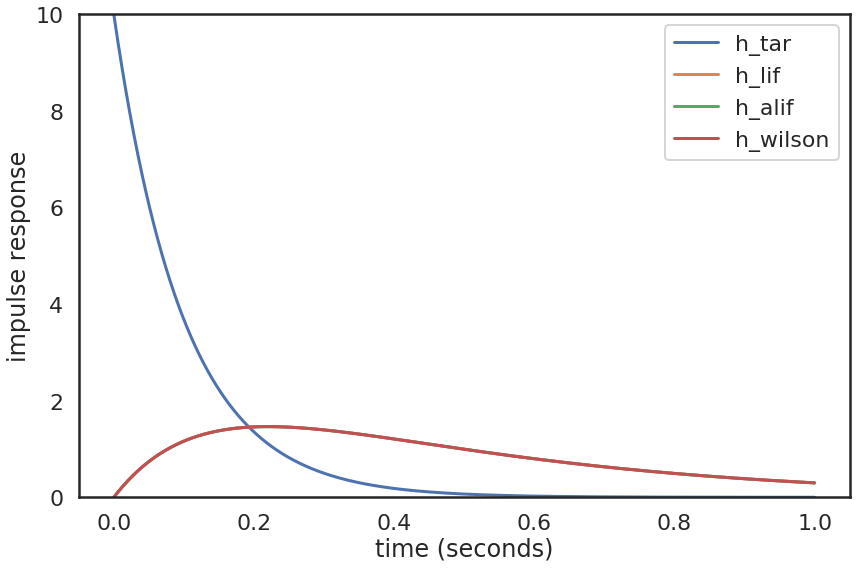

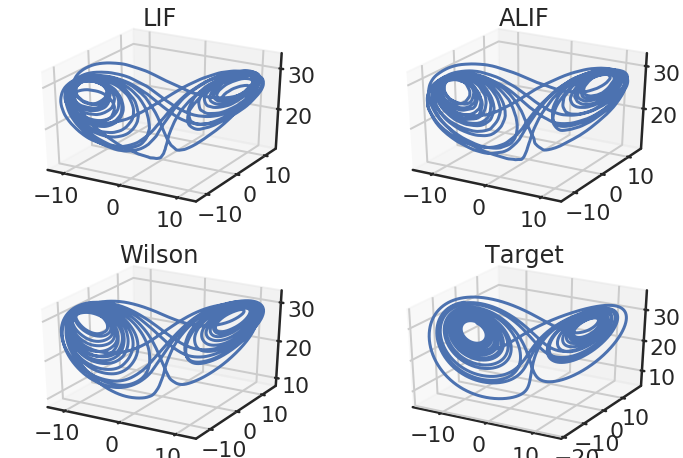

trial 0


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

MemoryError: 

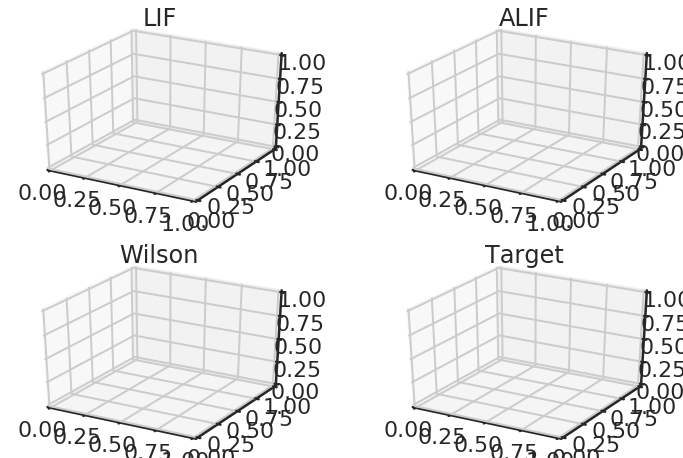

In [3]:
nrmses = go(n_neurons=3000, max_rates=Uniform(20, 40), dt=0.001, t_train=20, t_supv=10, t_test=30, n_trains=4, n_tests=4, h_iter=50)